In [1]:
#!pip install ruptures


In [2]:
NORUPTURES = False
try:
    import ruptures as rpt
except ModuleNotFoundError:
    print("WARNING: installation of raptures failed - movoing on without raptures analysis")
    NORUPTURES = True
import pylab as plt
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.optimize import minimize
import os

%matplotlib inline

In [3]:
#Move up to RAFTS directory
if os.getcwd().endswith('/RAFTS'):
    pass
else:
    os.chdir('../../')


In [4]:

from utils import filt_interp, dpar, dtan, lamb_eff_md, dcr_offset, celest_to_pa, inverse_Teff, inverseTeff, inverseWeff, lorentzian, find_min_max_adjacent, variance_weighted_mean, chrDistAng
import globals

from config import *

os.chdir(globals.ROOTDIR)


In [5]:
!pwd

/Users/fbianco/RAFTS


# data

In [6]:
flare = pd.read_csv("Outdata/flare_df.csv", index_col=0)#, names=["mjd", "dpar_detrended")
flare = flare.sort_values(by="mjd")
flare = flare.iloc[start:end]

In [7]:
flare.columns

Index(['mjd', 'time', 'dpar_smoothed', 'dparerr_smoothed', 'dpar_raw',
       'dpar_error', 'dpar_detrended', 'dparerr_detrended',
       'dpar_detrended_mean', 'dparerr_detrended_mean',
       'dpar_detrended_median', 'dparerr_detrended_iqr_low',
       'dparerr_detrended_iqr_high', 'dpar_detrended_weightedav',
       'dparerr_detrended_weightedav',
       'dpar_detrended_weightedav_detected_in_all_frames',
       'dparerr_detrended_weightedav_detected_in_all_frames', 'ensamble_dpar',
       'ensamble_dparerr', 'dpar_smoothed_median', 'dparerr_smoothed_median',
       'dpar_smoothed_mean', 'dparerr_smoothed_mean', 'g_mag', 'g_mag_error',
       'am'],
      dtype='object')

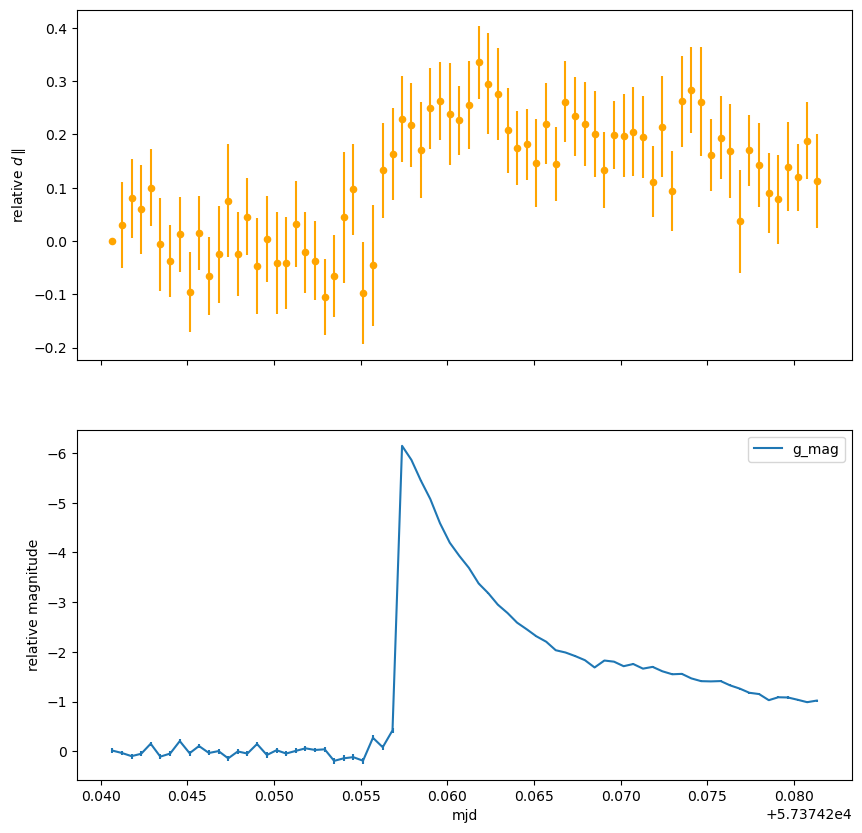

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(10,10), sharex=True)
ax0 = flare.plot("mjd", "dpar_detrended", kind="scatter", yerr="dparerr_detrended", ax=axs[0], color="orange")
ax0.set_ylabel(r"relative $d\parallel$")

ax1 = flare.plot("mjd", "g_mag", yerr="g_mag_error", ax=axs[1])
ax1.set_ylabel("relative magnitude")
ax1.invert_yaxis()

### Here we perform a statistical analysis of the existence of a statistically significant behaviour change in the time series of zenithward angle for the flaring star. 

### We demonstrate that the point if change exists, to a statistical significance of 5 sigma, which is to say a behavior as extreme as that  observed in the time series of $d\parallel$, the zenithward angle of the flaring star, has a 1 in 3.5 million chances of occurring by chance (note that the standard in astrophsyical data analysis is typically 3-sigma, or 1 in 997 chances of occurring by chance). 

## We identify the location of the point of change (POC) and assess its statistical significance, with different methods, to ensure the reader (or the referee) has no further doubts about our claim of an incredibly solid detection.

# chi square to a horizontal line

### NOTE: this analysis is the incorrect approach as described below! however, we include this naive test since it was what the referee implicitly suggested by claiming that the 1-2 sigma consistency of the points in the series implies no statistically robust detection. The key mistake here is that this apporoach implied the points are drawn from a IID and are independent, which of course they are not


Text(0, 0.5, 'relative $d\\parallel$')

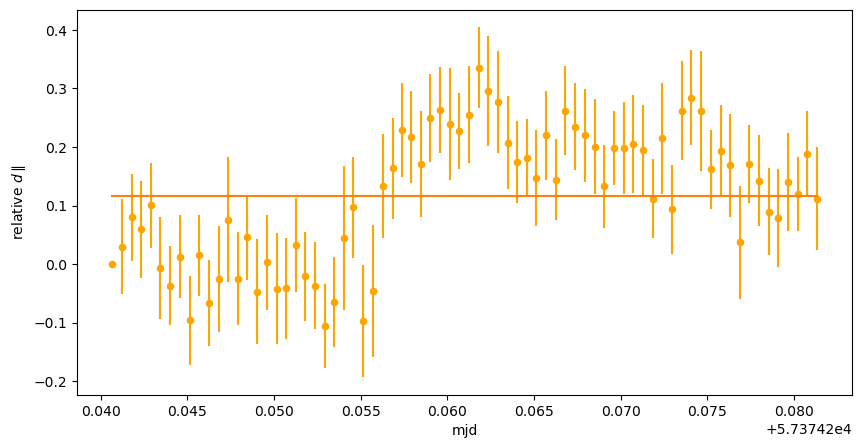

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(10,5), sharex=True)
axs = flare.plot("mjd", "dpar_detrended", kind="scatter", yerr="dparerr_detrended", ax=axs, color="orange")
axs.plot(flare["mjd"], [flare["dpar_detrended"].mean()]*(len(flare)))
axs.set_ylabel(r"relative $d\parallel$")

In [10]:
def chi2(a, b, e):
    """
    Return the square error between data points and a model

    Input:
      a: array of data points
      b: array of model points

    Output:
      square error: the square error between the data and the model
    """
    return np.sum((a - b)**2 / e**2)

In [11]:
chi2_mean = chi2(flare["dpar_detrended"], flare["dpar_detrended"].mean(), flare["dparerr_detrended"]) / (len(flare) - 1)
print("Chi2 with a horizontal line model with mean the mean of the entire dataset\n"
"(referee implicit suggestion): {:.2f}".format(chi2_mean))

Chi2 with a horizontal line model with mean the mean of the entire dataset
(referee implicit suggestion): 2.01


in the original dparr time series this was returning a <1 chi2. We updated the photometry to obtain more representative errors and this model is a poor fit. 


In [12]:
print("Are the uncertainties underestimated? they woudld be for a stationary time series")
print("Mean error {:.2f} | Standard deviation of the data {:.2f}".format(flare["dparerr_detrended"].mean(), flare["dpar_detrended"].std()))

Are the uncertainties underestimated? they woudld be for a stationary time series
Mean error 0.08 | Standard deviation of the data 0.11


### Regardless of the overestimation of the uncertainties, this is the wrong test: it assumes all points in the time series are IID which is obviously the wrong assumption since this is a series and the order matters!

# POINT OF CHANGE ANALYSIS (POC) - the right analysis to do

point of change analysis is a statistical framework to identify behavior changes in (time) series. A number of methods are described in this framework, we will test a few. Specifically we will use a few different methods to _identify_ the position of a point of change in the time series (under the assumption of 1 point of change to simplify the analysis) and we will use both frequentist and Bayesian methods to assess the significance of a point-of-change model compared to a stationary model (i.e. no point of change, no change in the property of the distribution the data comes from).

Generally, POC analysis tries to minimize (for m segments)

$$ \sum_{i=1}^{m+1} C(y[t_{i-1}:t_i]) + f(m) $$

where C is a cost function calculated for each segment and f(m) is a function of the number of segments: a regularizatoin introduced to avoid overfitting.

Since we are only interested in 1 POC, we will generally ignore any solution with m>1 and, where possible, impose a single POC solution



#### However, this is a naive method and, from the plot above, it is clear that it is sensitive to the significant scatter in the time series. 

### We can minimize a loss function representing tthe Chi2 with a gradient descent method
the model here is a piecewise stationary model with mean the mean of the piece

In [79]:
def loss_function(k, y, dy):
  # The loss function needs to return a single scalar value
  # Let's use the sum of squared errors around the means
  k = np.round(k * 1e7).astype(int)[0] # Ensure k is an integer
  if k < 1 or k >= len(y):
      return np.inf # Return a large value if k is out of bounds
  resid1 = (y[:k] - np.nanmean(y[:k]))**2 / np.nanmean(dy[:k])**2 
  resid2 = (y[k:] - np.nanmean(y[k:]))**2 / np.nanmean(dy[k:])**2 

  error = np.nansum(resid1) + np.nansum(resid2)
  return error

# We need an initial guess for k. Let's pick the middle index.
ig = int((flare["dpar_detrended"].shape[0] // 2))

print("initial guess", ig)
ig = ig * 1e-7
res = minimize(loss_function, ig, method="Nelder-Mead", bounds=[[0,70e-7]], options={"maxiter":300, "xatol":1e-10}, args=(flare["dpar_detrended"].values[3:-3],
                                                                                 flare["dparerr_detrended"].values[5:-5]))
poc_l2 = (res.x * 1e7).astype(int)[0] + 3
print(f"We find the most likely point of change is at index {poc_l2} ({flare.mjd[poc_l2]})")
if poc_l2 in [poc_chi2-1, poc_chi2+1]:
    print("With two different methods we find the same POC")
    



initial guess 37
We find the most likely point of change is at index 27 (57374.255702588875)


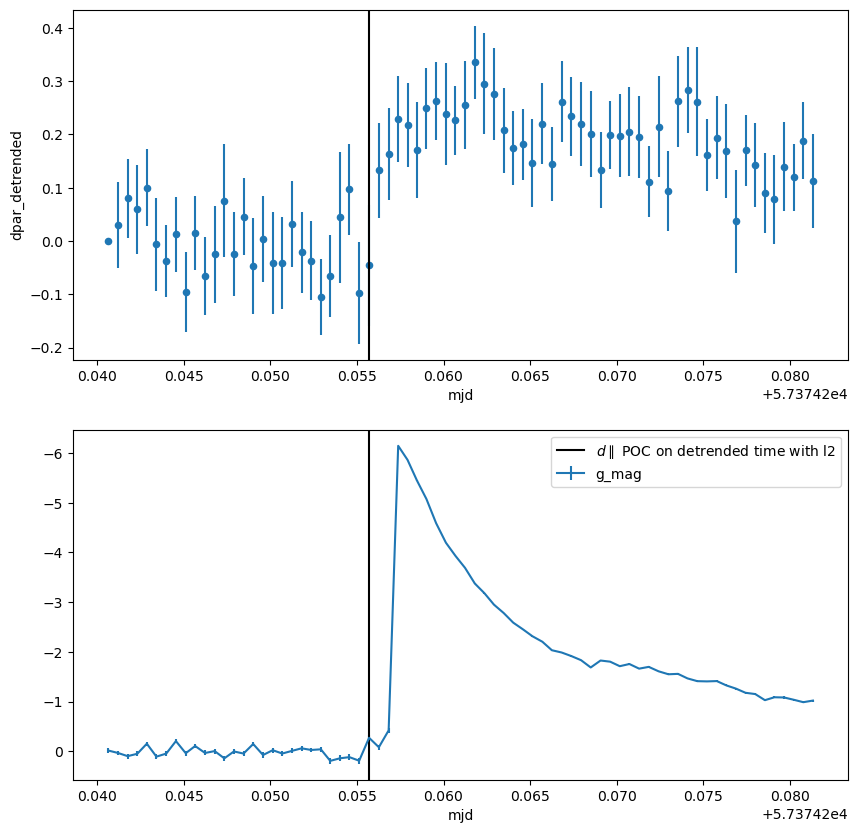

In [80]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
flare.plot("mjd", "dpar_detrended", kind="scatter", yerr="dparerr_detrended", ax=axs[0])
axs[0].axvline(flare.iloc[poc_l2]["mjd"], color='k', label=r"$d\parallel$ POC")
ax1 = flare.plot(x="mjd", y="g_mag", yerr="g_mag_error", ax=axs[1])
ax1.invert_yaxis()
axs[1].axvline(flare.iloc[poc_l2]["mjd"], color='k', label=r"$d\parallel$ POC on detrended time with l2")
plt.legend();

## Minimizind difference between means and associated model $\chi^2$
This is a two step minimization as suggested in the literature on POC: minimize first the difference between points and accept the solution iff it also minimizes the squared error assuming a piecewise stationary model again

In [81]:

def poc_mse(y, yerr):
    """
    Find the POC by assuming a single POC and minimizing the square error, as well as
    maximizing the difference in the means before and after the POC.

    Input:
      y: array of data for the endogenous variable

    Output:
      poc: index of the point of change
      before: mean before the point of change
      after: mean after the point of change
    """

    N = len(y)
    
    f = np.nanmean
    poc, diff, se, before, after = 0, 0, 1_000_000, np.nan, np.nan
    # This will find the state of change by maximizing the difference between the means before and after the poc

    for i in range(5, N-5):
        diff_here = np.abs(f(y[i:]) -  f(y[:i])) #difference between means before and after
        if diff < diff_here: #brute force minimization
            diff_g = diff_here
            poc_g = i
            before_g, after_g= f(y[:i]), f(y[i:]) #means before and after

            # create a 2 component step function model based on the point of the change determined here
            y_model = [before_g] * poc_g + [after_g] * (len(y) - poc_g)
            # find the square error of this model
            se_here = chi2(y, y_model, yerr)
            
            # if the squared error is smaller here, set the variables to be what it is at this point
            if se_here < se:
                se = se_here
                poc, before, after = poc_g, before_g, after_g
                diff = diff_g

    return(poc, before, after)
    
N = len(flare["dpar_detrended"])
poc_chi2_detr, beforepoc, afterpoc = poc_mse(flare["dpar_detrended"], flare["dparerr_detrended"])
poc_chi2, beforepoc, afterpoc = poc_mse(flare["dpar_smoothed"], flare["dparerr_smoothed"])
poc_chi2_detr += 3
poc_chi2 +=3
y_model = [beforepoc] * poc_chi2 + [afterpoc] * (N - poc_chi2)
print(f"POC found by minimizind difference between means and associated model chi2 at {poc_chi2_detr} on detrended series ({flare.mjd[poc_chi2_detr]})")
print(f"POC found by minimizind difference between means and associated model chi2 at {poc_chi2} on smoothed series ({flare.mjd[poc_chi2]})")



POC found by minimizind difference between means and associated model chi2 at 31 on detrended series (57374.25792112619)
POC found by minimizind difference between means and associated model chi2 at 30 on smoothed series (57374.25738249212)


57374.25683197735

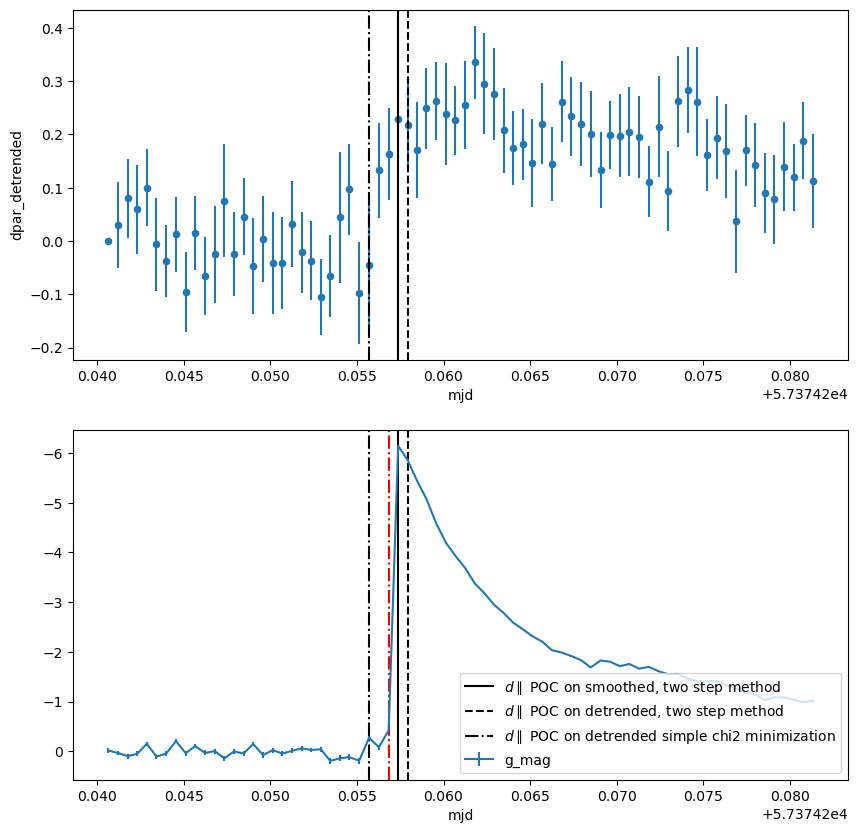

In [123]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
flare.plot("mjd", "dpar_detrended", kind="scatter", yerr="dparerr_detrended", ax=axs[0])
axs[0].axvline(flare.iloc[poc_chi2]["mjd"], color='k')
axs[0].axvline(flare.iloc[poc_l2]["mjd"], color='k', ls='-.')
axs[0].axvline(flare.iloc[poc_chi2_detr]["mjd"], color='k', ls='--')
ax1 = flare.plot(x="mjd", y="g_mag", yerr="g_mag_error", ax=axs[1])
ax1.invert_yaxis()
axs[1].axvline(flare.iloc[poc_chi2]["mjd"], color='k', label=r"$d\parallel$ POC on smoothed, two step method")
axs[1].axvline(flare.iloc[poc_chi2_detr]["mjd"], color='k', ls='--', label=r"$d\parallel$ POC on detrended, two step method")
axs[1].axvline(flare.iloc[poc_l2]["mjd"], color='k', ls='-.', label=r"$d\parallel$ POC on detrended simple chi2 minimization")
plt.legend(loc="lower right");

t_1000s = flare.time <= 1_000
flarestart = np.where(flare.g_mag <= flare.g_mag[t_1000s].median() - 4 * flare.g_mag[t_1000s].std())[0][0]
axs[1].axvline(flare.iloc[flarestart]["mjd"], color='r', ls='-.', label=r"flare start")
flare.iloc[flarestart]["mjd"]

#### Not only this method is more correct methodologically, but it identifies the POC in $d\parallel$ at what appears to be the beginning of the flare in magnitude

A fully Bayesian analysis is complicated by the decisions on the prior. Nonetheless, following Basseville and Nikiforov, implement the Girshick and Rubin, 1952 algorithm. We define a geometric prior $$P(t ~is ~POC) = \rho (1-\rho)^k$$ where $k$ is the index of the time series, and we set r to 0.5, thus rapidly decreasing the probability of a POC (conservative approach). We set the model as before to a piecewise Gaussian, but since we do not run this algorithm recursively, we start by setting the means to the mean of the first 20 points, and the mean of the last 20 points in the time series.
$$\rho*k*(1-\rho)^{k-1}$$

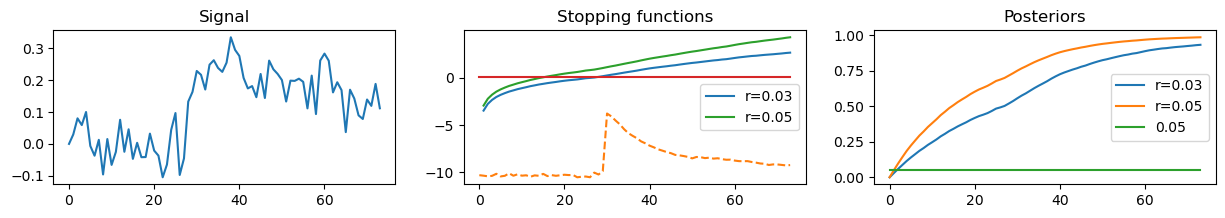

In [16]:
np.random.seed(302)
significance = 0.05
def p(y, theta, sigma=1):
  return 1 / sigma / np.sqrt(2*np.pi) * np.exp(-(y-theta)**2 / 2 / sigma**2) #gaussian

def loglik(y, k, thetas, sigma=1): #decision function
  #return np.array([s_i(yi, thetas) for yi in y]).sum()
  #return np.log(p(y[k], thetas[1]) / p(y[k], thetas[0])) 
  return (thetas[1] - thetas[0]) / sigma**2 * (y[k] - (thetas[0] + thetas[1]) / 2)


def prior(k, r=0.05):
    if k==0:
        return 0
    return r * (1-r)**(k-1)

def posterior(y, k, thetas, sigma, r, pis): 
  if k==0:
    return [0]
  if np.isnan(y[k]):
      return 0
  numerator = pis[k-1] * p(y[k], thetas[1]) #p(1|1)
  numerator += (1 - pis[k-1]) * r * p(y[k], thetas[1]) #p(1|0)
  denominator = numerator + (1 - pis[k-1]) * (1-r) * p(y[k], thetas[0]) #p(1|1) + p(1|0) + p(0|0)
  return numerator / denominator #np.min([0.9, numerator / denominator])

def pomega(pi, k):
    if k==0:
        return 0
    return pi[k] / (1 - pi[k])

def pomega_recursive(pi, k, r, thetas, y):
    if k == 0:
      pomega(pi, k)
    return pomega(pi,k)
    
def g(pi, k, r, thetas, y):
    return np.log(pomega_recursive(pi, k, r, thetas, y))
  
def g_recursive(pi, k, r, thetas, y):
    _ = np.log(pomega_recursive(pi, k, r, thetas, y))
    return _#    np.log(p(y[k], thetas[1]) / p(y[k], thetas[0]))
    

#pis = [posterior(signal, i, [0,10], 1, r, pis) for i in range(0,1)] + [posterior(signal, i, [0,10], 1, r, pis) for i in range(1,N)]
fig, axs = plt.subplots(1,3, figsize=(15,2))

signal = flare.fillna(method='ffill')["dpar_detrended"].values #note: no more nans but leaving ffill nan method for generalizability

#signal = np.hstack([1 * np.random.randn(25),  (np.random.randn(25) + 4)])
axs[0].plot(signal)# / signal.max())
r=0.03

#parameters
thetas = [np.nanmean(signal[:20]), np.nanmean(signal[20:])] 

#priors
priors = [prior(i, r) for i in range(N)] 

#posteriors
pis = posterior(signal, 0, thetas, 1, r, None) 
for i in range(1,N):
  pis.append(posterior(signal, i, thetas, 1, r, pis) )

#stopping function
gs = [g(pis, 0, r, thetas, signal)]
for i in range(1,N):
  gs.append(g_recursive(pis, i, r, thetas, signal) )

axs[1].plot(gs, label=f"r={r}")
axs[1].plot(range(len(flare["g_mag"])),-(flare["g_mag"]-flare["g_mag"].min())/np.ptp(flare["g_mag"]) * np.ptp(axs[1].get_ylim()) + axs[1].get_ylim()[0], '--')
axs[2].plot(list(range(N)), pis, label=f"r={r}")

r=0.05

#priors
priors = [prior(i, r) for i in range(N)] 

#posteriors
pis = posterior(signal, 0, thetas, 1, r, pis) 
for i in range(1,N):
  pis.append(posterior(signal, i, thetas, 1, r, pis) )

#stopping function
gs = [g(pis, 0, r, thetas, signal)]
for i in range(1,N):
  gs.append(g_recursive(pis, i, r, thetas, signal) )


axs[0].set_title("Signal")

axs[1].plot(gs, label=f"r={r}")
axs[1].set_title("Stopping functions")
axs[2].plot(list(range(N)), pis, label=f"r={r}")
axs[2].set_title("Posteriors")
axs[1].legend()
axs[1].plot([significance] * N, label=f"{significance}")
axs[2].plot([significance] * N, label=f"{significance}")
axs[2].legend()


This analysis is designed for _online_ point of change detection. The stopping function is used in industry applications to identify the beginning of a malfunction. In our case, it points to the best place where to put a PoC which, is found at the  stopping function with 97% probability crosses the threshold at the beginning of the flare in photometry (although the analysis is done entirely in d_parallel space!). The posterior distribution finds a PoC at in the time series in at both 0.05 (2 sigma) and 0.03 significance when the whole time series is considered.

In [17]:
def Sjk(y, j, k, thetas, sigma=1):
    return (thetas[1] - thetas[0]) / sigma**2 * np.sum(y[j:k] - (theta[1] + theta[0]) / 2)
    
    
def gk(thetas, j, k):
    nu_j = 1 / (k - j + 1) * np.sum(np.abs(y[j:k] - theta[0]) - thetas[1] - thetas[0])
    _= np.sum((2 * nu * (y[j:k] - thetas[0]) - nu**2) / sigmas**2)              
    np.max()

In [18]:
signal

array([ 0.        ,  0.02975756,  0.08037879,  0.05919   ,  0.10031432,
       -0.00640277, -0.03707646,  0.01282605, -0.09601054,  0.01524335,
       -0.06598027, -0.02522809,  0.07582055, -0.02472074,  0.04586583,
       -0.04705465,  0.00342302, -0.04176904, -0.04134879,  0.03230777,
       -0.02105411, -0.03687585, -0.10492706, -0.06489738,  0.04434282,
        0.09697314, -0.09761283, -0.04562418,  0.13293259,  0.16350442,
        0.22929437,  0.21722051,  0.17094099,  0.24893266,  0.26303389,
        0.23875317,  0.22646379,  0.25538559,  0.3352054 ,  0.29562335,
        0.27655112,  0.20751207,  0.17442871,  0.18178371,  0.14684113,
        0.21994101,  0.14431559,  0.26187948,  0.23449625,  0.21992327,
        0.20073304,  0.13317127,  0.19887232,  0.19808812,  0.20503161,
        0.19512228,  0.11170028,  0.21467871,  0.0938123 ,  0.26214371,
        0.28389052,  0.26148199,  0.16191007,  0.19383428,  0.16912044,
        0.03703905,  0.1703448 ,  0.14261488,  0.08978922,  0.07

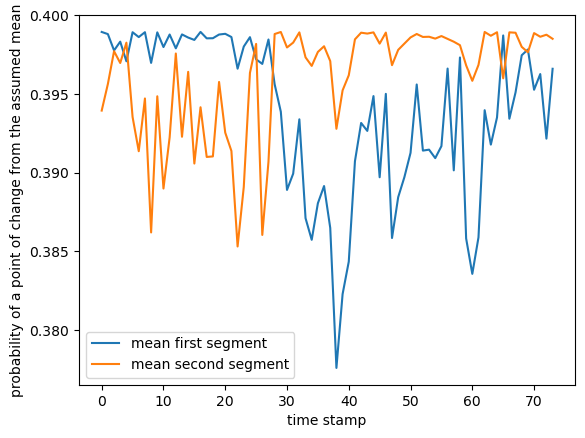

In [19]:
p0s = p(signal, thetas[0])#np.array([p(signal, thetas[0]) for k in range(N)])
p1s = p(signal, thetas[1])#np.array([p(signal, thetas[1]) for k in range(N)])

plt.plot(p0s, label="mean first segment")
plt.plot(p1s, label="mean second segment")
plt.legend()
plt.xlabel("time stamp")
plt.ylabel("probability of a point of change from the assumed mean");

With this method the point of change is found slightly erlier than the peak of the flare, but the flare has already started at that point: the photometry is rising significantly (note the uncertainties are really small) and the star is already bluer. That is: assuming a model piecewise stationary we find the point of change at the very start of the flare, three points before the peak. Regardless of exactly where, which depends on the model, there is clearly a point of change in the time series!

# Picking a POC location

In [22]:
poc = poc_chi2
print(f'The most likely point of change (POC) is found at MJD {flare.iloc[poc]["mjd"]}')

The most likely point of change (POC) is found at MJD 57374.25738249212


We choose the POC location at the peak of the flare, because that location is validated by the change in brightness.

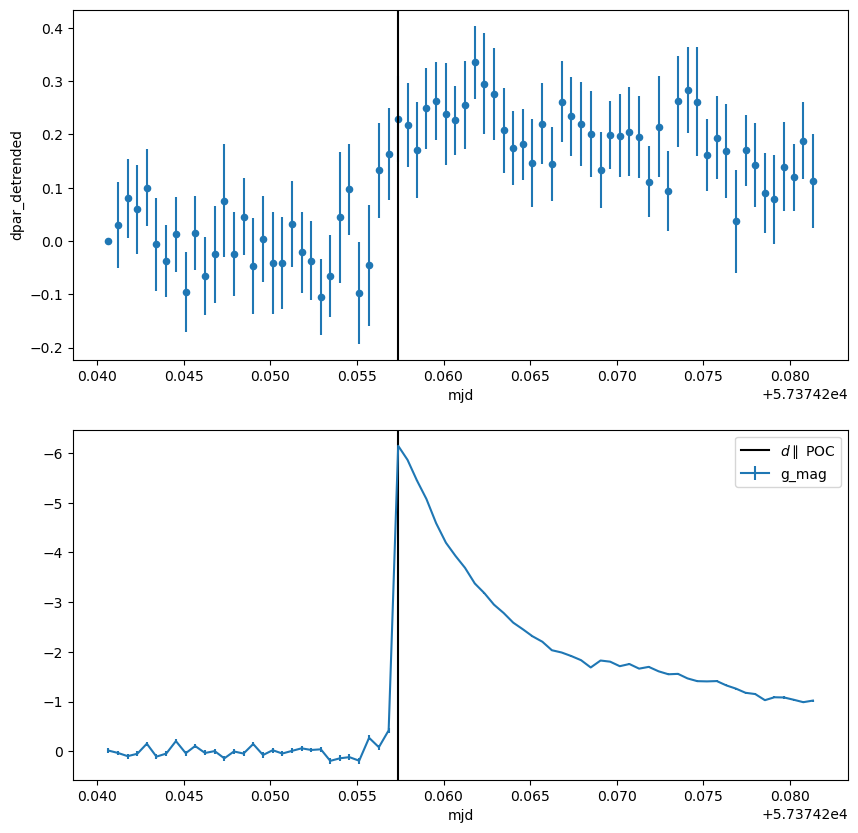

In [72]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
flare.plot("mjd", "dpar_detrended", kind="scatter", yerr="dparerr_detrended", ax=axs[0])
axs[0].axvline(flare.iloc[poc]["mjd"], color='k', label=r"$d\parallel$ POC")
ax1 = flare.plot(x="mjd", y="g_mag", yerr="g_mag_error", ax=axs[1])
ax1.invert_yaxis()
axs[1].axvline(flare.iloc[poc]["mjd"], color='k', label=r"$d\parallel$ POC")
plt.legend();


# With a candidate POC we can run statistical tests to assess its significance.


## Generative data model
In order to test the significance of the POC we need to establish a generative model for the data. For simplicity, we use a stationary Gaussian model, and a piece-wise Gaussian stationary model with mean consistent with the segment mean and stadard deviation derived from both the uncertainty and the data scatter (since we know the uncertainties are overestimated). We do not imply to argue that the true generative model for the data during the flare is a stationary process, but this is a conservative approach, since ignoring the physically motivated $d\parallel$ evolution after the start would have an even higher likelihood compared to the former

Chi2 of the step-function model with early and late average stationary states 0.66


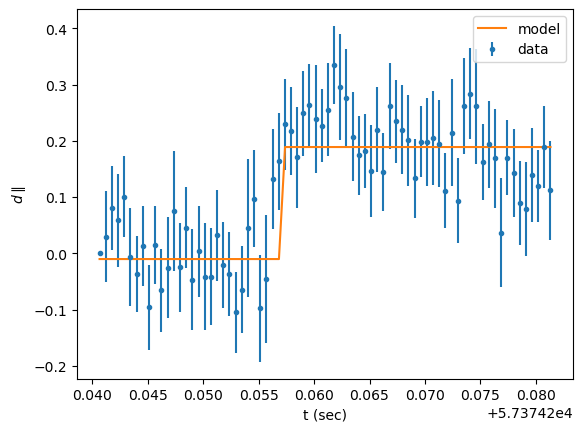

In [24]:
chi2_poc = chi2(flare["dpar_detrended"], y_model, flare["dparerr_detrended"]) / (N-1)
print("Chi2 of the step-function model with early and late average stationary states {:.2g}".format(chi2_poc))


plt.errorbar(x=flare["mjd"], y=flare["dpar_detrended"], yerr=flare["dparerr_detrended"], fmt='.', label="data")
plt.plot(flare["mjd"], y_model, label="model")
plt.xlabel('t (sec)')
plt.ylabel(r'$d\parallel$')
plt.legend();

### Mann-Whitney U test 

Start with a simple frequentist test: the Mann-Whitney U test is a nonparametric test of the null hypothesis
that the distribution underlying sample `x` is the same as the
distribution underlying sample `y`. It is often used as a test of
difference in location between distributions.


In [25]:
#perform a Mann-Whitney U Test on the first 23 datapoints of the flare dp and the rest of the time series

def mwtest(a, b):
  # Perform the Mann-Whitney U test
  u_statistic, p_value = mannwhitneyu(a, b,
                                      alternative='less')
  # Print the results
  print(f"Mann-Whitney U statistic: {u_statistic}")
  print("P-value: {:.2g}".format(p_value))

  # Interpret the results (common significance level is 3 and 5 sigma)
  alpha = 0.003 # 3 sigma
  if p_value < alpha:
      print("The difference between the two groups is statistically significant at 3-sigma.")
  else:
      print("There is no statistically significant difference between the two groups.")

  alpha = 0.00006 # 5 sigma
  if p_value < alpha:
      print("The difference between the two groups is statistically significant at 5-sigma.")
  else:
      print("There is no statistically significant difference between the two groups at 5 sigma.")

mwtest(flare.iloc[:poc_chi2]["dpar_detrended"].dropna(), flare.iloc[poc_chi2:]["dpar_detrended"].dropna())

Mann-Whitney U statistic: 34.0
P-value: 2.9e-12
The difference between the two groups is statistically significant at 3-sigma.
The difference between the two groups is statistically significant at 5-sigma.


In [26]:
# prompt: perform a Mann-Whitney U Test on the first 23 datapoints of the flare dp and the rest of the time series

def mwtest(a, b):
  # Perform the Mann-Whitney U test
  u_statistic, p_value = mannwhitneyu(a, b,
                                      alternative='two-sided')
  # Print the results
  print(f"Mann-Whitney U statistic: {u_statistic}")
  print("P-value: {:.2g}".format(p_value))

  # Interpret the results (common significance level is 3 and 5 sigma)
  alpha = 0.003 # 3 sigma
  if p_value < alpha:
      print("The difference between the two groups is statistically significant at 3-sigma.")
  else:
      print("There is no statistically significant difference between the two groups.")

  alpha = 0.00006 # 5 sigma
  if p_value < alpha:
      print("The difference between the two groups is statistically significant at 5-sigma.")
  else:
      print("There is no statistically significant difference between the two groups at 5 sigma.")

mwtest(flare.iloc[:poc]["dpar_detrended"].dropna(), flare.iloc[poc:]["dpar_detrended"].dropna())

Mann-Whitney U statistic: 34.0
P-value: 5.7e-12
The difference between the two groups is statistically significant at 3-sigma.
The difference between the two groups is statistically significant at 5-sigma.


# Bayesian assessments of the statistical significance of the existance of a POC

### The Bayes factor test


In a Bayesian framework, we assume that the underlying distribution of datapoint is Gaussian and we compare a model where all points come from the same Gaussian generative process and models where, consistently with a point of change analysis, the mean of the Gaussian distribution is different before and after the POC. 

The Bayes factor Bf is defined as

$$ B_f= \frac{P(D | M_{POC})}{P(D|M_{noPOC})} $$


Following Bayes thoerem, the ration $B_f$ defined above is equivalent to $\frac{P(H|E)}{P(Hc|E)} \cdot \frac{P(E)}{P(E)} \cdot \frac{P(Hc)}{P(H)}$ where H is the hypothesis, H_c  is the complement of the hypothesis, E is the evidence, and P denotes probability. Assuming a flat prior on both models (and cancelling out the probability of the evidence that appears at both numerator and denominator) this is equivalent to:


$$B_f
 =
\frac{P(H∣E)}{P(H_c ∣E)} = \frac{P(M_{POC}∣D)}{P(M_{noPOC} ∣D)}$$
​
A Bayes factor greater than 1 indicates that the data favor the numerator (POC) hypothesis over the denominator (no POC) hypothesis, while a factor less than 1 suggests the opposite.

When interpreting Bayes factors, a commonly used scale by Harold Jeffreys (_Jeffreys, Harold (1998) [1961]. The Theory of Probability (3rd ed.). Oxford, England. p. 432. ISBN 9780191589676_) suggests that a Bayes factor of 1 to 3 is "not worth more than a bare mention," 3 to 20 is "substantial," 20 to 150 is "strong," and above 150 is "very strong".



In [29]:
# bayes factor
def interpretation_HJ61(Bf):
    if  Bf <= 1 :
        print("the analysis does not favor the point of change model")
    elif Bf <=3:
        print("the POC model is only weakly favored")
    elif Bf <= 20:
        print("there is substantial statistical evidence in favor or the POC model")
    elif Bf <= 150:
        print("there is strong statistical evidence in favor or the POC model")
    else:
        print("there is very strong statistical evidence in favor or the POC model")

def gauss(x, m, s):
  """Probabilitiy of x according to a Gaussian distribution"""
  #print(np.exp(-((x-m)/s)**2 / 2 ))
  return  np.prod(np.exp(-((x-m)/s)**2 / 2))

def nochangemodel(y, sigmas=None):
  """Model with no POC"""
  m = y.mean()
  if sigmas is None:
    sigmas = [y.std()]
  #print(f"Using standard deviaition {sigmas}")
  return gauss(y, m, sigmas[0]) #prod of independent prob of point being drawn under single Gaussian

def cpmodel(y, k, sigmas=None):
  """Model with 1 POC"""
  m1 = y[:k].mean()
  m2 = y[k:].mean()
  if sigmas is None:
    sigmas = [y.std()] * 2
  #print(f"Using standard deviation {sigmas}")
  """
  try:
      print(sigmas[0], len(sigmas[0]), len(m1))
  except:
      pass
  """
  return gauss(y[:k], m1, sigmas[0]) * gauss(y[k:], m2, sigmas[1])


In [31]:
gauss(flare.dpar_detrended[:poc], 2, 2)
mjd_poc = flare["mjd"].iloc[poc]
print(f"POC MJD {mjd_poc}")

POC MJD 57374.25738249212


In [32]:
y = flare["dpar_detrended"].fillna(method="ffill")#[:58]
e = flare["dparerr_detrended"].fillna(method="ffill")

print("Using sandard dev of the whole time series for the Gaussian distributions (conservative)")

M_nochange = nochangemodel(y)
M_poc = cpmodel(y, poc)
Bf = M_poc / M_nochange
print("Bayesian P no change: {:.2g}".format(M_nochange))
print("Bayesian P 1 change: {:.2g}".format(M_poc))
print("Bayes odds ratio: {:.2g}".format(Bf))
interpretation_HJ61(Bf)

Using sandard dev of the whole time series for the Gaussian distributions (conservative)
Bayesian P no change: 1.4e-16
Bayesian P 1 change: 6.4e-06
Bayes odds ratio: 4.5e+10
there is very strong statistical evidence in favor or the POC model


In [33]:
print("Using the average error as st dev of the time series throughout")
s = flare["dparerr_detrended"].mean()
M_nochange = nochangemodel(y, sigmas=[s])
M_poc = cpmodel(y, poc, sigmas=[e.iloc[:poc].mean(), e.iloc[poc:].mean()])
Bf = M_poc / M_nochange

print("Using mean measured error of the whole time series for the Gaussian distributions)")
print("Bayesian P no change: {:.2g}".format(M_nochange))
print("Bayesian P 1 change: {:.2g}".format(M_poc))
print("Bayes odds ratio: {:.2g}".format(Bf))

interpretation_HJ61(Bf)

Using the average error as st dev of the time series throughout
Using mean measured error of the whole time series for the Gaussian distributions)
Bayesian P no change: 2.9e-32
Bayesian P 1 change: 4.8e-11
Bayes odds ratio: 1.7e+21
there is very strong statistical evidence in favor or the POC model


In [34]:
print("Using the measurement uncertainties")
s = flare["dparerr_detrended"].mean()
M_nochange = nochangemodel(y, sigmas=[s])
M_poc = cpmodel(y, poc, sigmas=[e.iloc[:poc], e.iloc[poc:]])
Bf = M_poc / M_nochange

print("Using mean measured error of the whole time series for the Gaussian distributions")
print("Bayesian P no change: {:.2g}".format(M_nochange))
print("Bayesian P 1 change: {:.2g}".format(M_poc))
print("Bayes odds ratio: {:.2g}".format(Bf))

interpretation_HJ61(Bf)

Using the measurement uncertainties
Using mean measured error of the whole time series for the Gaussian distributions)
Bayesian P no change: 2.9e-32
Bayesian P 1 change: 4.2e-11
Bayes odds ratio: 1.4e+21
there is very strong statistical evidence in favor or the POC model



### Likelihood Ratio Test

We can also perfrorm a likelihood ration test. This test is similar, but only valid when the models are nested and it provides a p-value assessment of the statistical significant: the likelihood ration is defines as 

$${\displaystyle \lambda _{\text{LR}}=-2\left[~\ell (\theta _{0})-\ell ({ {\theta }})~\right]}$$
where

 
$${\displaystyle \ell ({{\theta }})\equiv \ln \left[~\sup _{\theta \in \Theta }{\mathcal {L}}(\theta )~\right]~}$$ or the maximized loglikelihood of the model. We use the same models above: a stationary Gaussian generative process and a piecewise Gaussian locally stationary process, with different assumptions on standard deviation. 

The resulting $\lambda_R$ is expected to be $\chi_n^2$ distributed under the null hypothesis (no POC) where $n$ denotes the number of degrees of freedom of the $\chi^2$ distribution, which is set to the difference in degrees of freedom (i.e. parameters) in the two models. Under our models, $n=3$ since there are 3 additional parameters in the non-stationary model: the mean and standarad deviation of the second Gaussian segment, and the location of the POC")


In [35]:
# bayes factor
def loglikelihood(x, m, s):
  """Likellihood of x according to a Gaussian distribution"""
  return  -(x-m)**2 / 2 / s**2

def nochangellik(y, sigmas=None):
  """Model with no POC"""
  m = y.mean()
  if sigmas is None:
    sigmas = [y.std()]
  #print(f"Using standard deviaition {sigmas}")
  return np.sum(loglikelihood(y, m, sigmas[0])) #prod of independent prob of point being drawn under single Gaussian

def cpmodelllik(y, k, sigmas=None):
  """Model with 1 POC"""
  m1 = y[:k].mean()
  m2 = y[k:].mean()
  if sigmas is None:
    sigmas = [y.std()] * 2
  #print(f"Using standard deviation {sigmas}")

  return np.sum(loglikelihood(y[:k], m1, sigmas[0])) + np.sum(loglikelihood(y[k:], m2, sigmas[1]))

def lrf(l1, l2):
    return -2 * ((l1 - l2))
    
M_nochange = nochangellik(y, sigmas=[y.std()])
M_poc = cpmodelllik(y, poc, sigmas=[y.std()]*2) #[y.iloc[:poc].std(), y.iloc[poc:].std()])
lr = lrf(M_nochange, M_poc) 

print("Using sandard dev of the whole time series for the Gaussian distributions (conservative)")
print("Log Likelihood no change: {:.2f}".format(M_nochange))
print("Log Likelihood 1 change: {:.2f}".format(M_poc))
print(r"Likelihood ratio: {:.2g}".format(lr))
print("Associated p-value (from chi2 disribution with 2 degrees of freedom when using a single sigma) {:.2g}".format(1 - stats.chi2.cdf(lr, 2)))


Using sandard dev of the whole time series for the Gaussian distributions (conservative)
Log Likelihood no change: -36.50
Log Likelihood 1 change: -11.97
Likelihood ratio: 49
Associated p-value (from chi2 disribution with 2 degrees of freedom when using a single sigma) 2.2e-11


In [36]:
M_nochange = nochangellik(y, sigmas=[e.mean()])
M_poc = cpmodelllik(y, poc, sigmas=[e.iloc[:poc].mean(), e.iloc[poc:].mean()]) #[y.iloc[:poc].std(), y.iloc[poc:].std()])
lr = lrf(M_nochange, M_poc) 

print("Using mean errors (which are underestimated) for each segment of the piece-wise model for the Gaussian distribution standard deviation (conservative)")
print("Likelihood no change: {:.2g}".format(M_nochange))
print("Likelihood 1 change: {:.2g}".format(M_poc))
print("Likelihood ratio: {:.2g}".format(lr))
print("Associated p-value (from chi2 disribution with 3 degrees of freedom) {:.2g}".format(1 - stats.chi2.cdf(lr, 3)))


Using mean errors (which are underestimated) for each segment of the piece-wise model for the Gaussian distribution standard deviation (conservative)
Likelihood no change: -73
Likelihood 1 change: -24
Likelihood ratio: 98
Associated p-value (from chi2 disribution with 3 degrees of freedom) 0


In [37]:
M_nochange = nochangellik(y, sigmas=[e.mean()])
M_poc = cpmodelllik(y, poc, sigmas=[e.iloc[:poc], e.iloc[poc:]]) #[y.iloc[:poc].std(), y.iloc[poc:].std()])
lr = lrf(M_nochange, M_poc) 

print("Using the uncertainties as they are")
print("Likelihood no change: {:.2g}".format(M_nochange))
print("Likelihood 1 change: {:.2g}".format(M_poc))
print("Likelihood ratio: {:.2g}".format(lr))
print("Associated p-value (from chi2 disribution with 2 degrees of freedom) {:.2g}".format(1 - stats.chi2.cdf(lr, 2)))


Using the uncertainties as they are
Likelihood no change: -73
Likelihood 1 change: -24
Likelihood ratio: 97
Associated p-value (from chi2 disribution with 2 degrees of freedom) 0


In [38]:
p_value = -stats.norm.ppf((1 - stats.chi2.cdf(lr, 3)) / 2)
p_value

inf

# Conclusions

We thus conclude that
- the most likely point of change in the $d\parallel$ time series is located at  MJD = 57374.25738249212 which is also the beginning of the flare activity (flare activity may begin a few datapoints earlier and the POC is found two points earlier with a differnt method but keep in mind that the transition is not as sharp for d_parallel as it is for magnitude - as shown in the literature --- see paper).
- Under all assumptions on models, which are generally conservative, the significance of the point of change is extremely high. With some dependence on the details of the generative model, it is higher than 5-sigma. In one case, using the likelihood ratio test with uncertainty set to the average of the data scatter, the significance drops. This is due to the fact that the piecewise stationary model is actually just a bad model for the flare activity. 

# Appendix: Using a standard package for point of change analysis

While this point of change analysis was computationally trivial, as it is not "online" and the data is one-dimensional and small, there exist standard packages for POC analysis, that are generally focused on computational efficiency in POC analysis, especially for online frameworks by applying accepted methodologies. We further analyze our data with the ```raptures``` package in python, which provides implementations for several standard algorithms for point of change analysis. In particlar: it implements kernel based methods for multiple POC finding described in _Celisse, A., Marot, G., Pierre-Jean, M., & Rigaill, G. (2018). New efficient algorithms for multiple change-point detection with reproducing kernels. Computational Statistics and Data Analysis, 128, 200–220_.

Below, we run the POC kernel finder with a Gaussian kernel defined as $$ rbf = exp(-\gamma(\mu_{t-1:t}))) $$ where $\gamma$ is a model hyperparameter. We test values of gamma from 1 (minimum allowed) to $\gamma$ such that we find additional points of changes

In [41]:
if NORUPTURES:
    exit

In [ ]:
for gamma in range(11):# gamma = 1
  algo = rpt.KernelCPD('rbf', params={'gamma':gamma})
  algo.fit(flare["dpar_detrended"].fillna(method="ffill").values)
  result = algo.predict(pen=1)
  poc_kcpd = result[0]
  print(f"gamma={gamma} ----- found {len(result) - 1} POCs at {poc_kcpd}")
  # display
  rpt.display(flare["dpar_detrended"], [poc_kcpd], result);
  plt.xlabel('t (sec)')
  plt.ylabel('dp');
  plt.show()

with $\gamma<7$ we find a single point of change at the 23rd datapoint.  Increasing $7<=\gamma<10$ we find two, three, and four points of change, the first still at the 21st datapoint which is consistent with the earlier analysis.


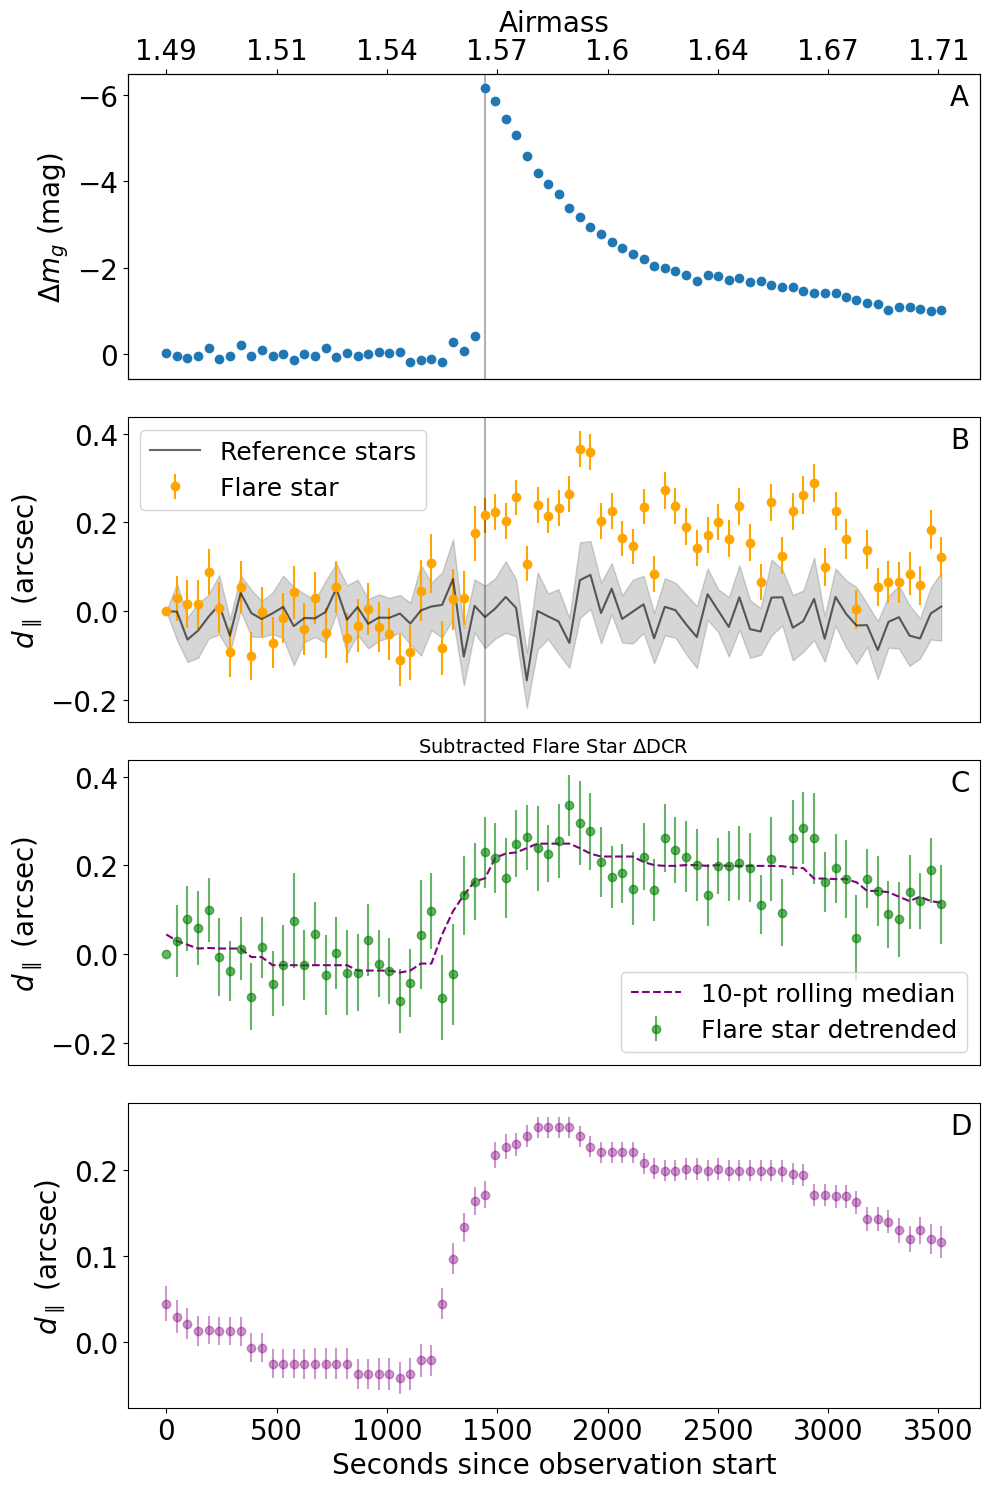

In [78]:
window=10
PLOT =True
if PLOT:
    fig, ax = plt.subplots(4,1, figsize=(10,15))

    ax[0].errorbar(flare.time, flare.g_mag, yerr = flare.g_mag_error, 
                   color='C0', marker='o', ls='None')
    ax[0].set_ylabel(r'$\Delta m_g$ (mag)', fontsize=14)
    ax[0].set_ylim(ax[0].get_ylim()[::-1])
    ax[0].set_xticks([])



    ax[1].errorbar(flare.time, flare.dpar_raw, yerr = flare.dpar_error, 
                   color='orange', marker='o', ls='None', label='Flare star')
    ax[1].plot(flare.time, flare.ensamble_dpar, c='k', alpha = 0.6, label='Reference stars')
    ax[1].fill_between(flare.time, flare.ensamble_dpar-flare.ensamble_dparerr, 
                       flare.ensamble_dpar+flare.ensamble_dparerr, 
                       color='#333333', alpha = 0.2)
    #ax[0].set_xlabel('Seconds since observation start')
    ax[1].set_ylabel(r'$d_\parallel$ (arcsec)', fontsize=14)
    #ax[1].set_title(r'Flare Star $\Delta$DCR', fontsize=14)
    ax[1].legend(loc='upper left', fontsize=18)
    ax[1].set_xticks([])

    ax[2].errorbar(flare.time, flare.dpar_detrended, yerr = flare.dparerr_detrended, 
                color='green', marker='o', alpha=0.6, ls='None', label='Flare star detrended')
    ax[2].plot(flare.time, flare.dpar_smoothed, 
               color='purple', ls='--', label='{}-pt rolling median'.format(window))

    
    ax[2].set_title(r'Subtracted Flare Star $\Delta$DCR', fontsize=14)
    ax[2].set_ylabel(r'$d_\parallel$ (arcsec)', fontsize=14)
    ax[2].set_ylim(ax[1].get_ylim())
    ax[2].legend(loc='lower right', fontsize=18)
    ax[2].set_xticks([])

    ax[3].errorbar(flare.time, flare.dpar_smoothed, yerr = flare.dparerr_smoothed, 
                   color='purple', alpha=0.4, ls='None', marker='o')
    ax[3].set_xlabel('Seconds since observation start', fontsize=14)
    ax[3].set_ylabel(r'$d_\parallel$ (arcsec)', fontsize=14)
    #ax[3].set_title(r'Subtracted + Smoothed Flare Star $\Delta$DCR', fontsize=14)

    subax0 = ax[0].twiny()
    subax0.set_xticks(ax[3].get_xticks())
    subax0.set_xticklabels(np.round(flare.am[::8], decimals=2), fontsize=12)
    subax0.set_xlim(ax[0].get_xlim())
    subax0.set_xlabel('Airmass', fontsize=20)
    subax0.tick_params(labelsize=20)

    for axis, label in zip(ax, ['A', 'B', 'C', 'D']):
        axis.annotate(label, xy=(0.965,0.9), xycoords='axes fraction', fontsize=20)
        axis.tick_params(axis='both', labelsize=20)
        axis.set_xlabel(axis.get_xlabel(), fontsize=20)
        axis.set_ylabel(axis.get_ylabel(), fontsize=20)


    fig.tight_layout()
    ax[0].axvline(flare.iloc[poc]["time"], color='k', alpha=0.3)
    ax[1].axvline(flare.iloc[poc]["time"], color='k', alpha=0.3)

    plt.savefig('Figures/subtractedrolled_dpar.png', dpi = 300, bbox_inches='tight')
